In [1]:
import sys
sys.path.append('..')

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import scanpy as sc
import anndata as ad
import scmulti
from random import shuffle
from scipy import sparse

In [4]:
%config InlineBackend.figure_format = 'retina'

# Load the dataset

In [5]:
scrna = sc.read_h5ad('../data/kotliarov-2020/expressions.h5ad')
scrna

AnnData object with n_obs × n_vars = 53196 × 3999
    obs: 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'batch', 'cluster_level1', 'cluster_level2', 'cluster_level3', 'sample'
    var: 'gene_symbols', 'n_cells', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'batch_colors', 'cluster_level1_colors', 'cluster_level2_colors', 'cluster_level3_colors', 'hvg', 'neighbors', 'pca', 'sample_colors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [6]:
cite = sc.read_h5ad('../data/kotliarov-2020/protein.h5ad')
cite

AnnData object with n_obs × n_vars = 53196 × 87
    obs: 'n_genes', 'batch', 'cluster_level1', 'cluster_level2', 'cluster_level3', 'sample'
    var: 'gene_symbols', 'n_cells'
    uns: 'batch_colors', 'cluster_level1_colors', 'cluster_level2_colors', 'cluster_level3_colors', 'neighbors', 'pca', 'sample_colors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

## Clean the data

In [7]:
# use more general annotation
# can change to cluster_level2 or cluster_level3 if needed (finer annotation)
scrna.obs['cell_type'] = scrna.obs['cluster_level1'].astype(str)
cite.obs['cell_type'] = cite.obs['cluster_level1'].astype(str)

# Paired setting

## Configure and train the model

In [9]:
# unpaired
model = scmulti.models.MultiVAE(
    adatas=[[scrna], [cite]],
    names=[['scRNA-seq'], ['scCITE-seq']],
    pair_groups=[[0], [0]],
    z_dim=20,
    h_dim=128,
    hiddens=[],
    shared_hiddens=[],
    adver_hiddens=[],
    recon_coef=1,
    kl_coef=1e-5,
    integ_coef=1e-2,
    cycle_coef=0,
    adversarial=False,
    dropout=0.2,
)

In [10]:
model.train(
    n_iters=10000,
    batch_size=256,
    lr=3e-4,
    val_split=0.1,
    adv_iters=0,
)

In [11]:
z = model.predict(
    adatas=[[scrna], [cite]],
    names=[['scRNA-seq'], ['scCITE-seq']],
    batch_size=256,
)
z

AnnData object with n_obs × n_vars = 106392 × 20
    obs: 'modality', 'cell_type', 'batch'

## Recover and visualize the latent space

In [12]:
sc.tl.pca(z, svd_solver='arpack')

... storing 'modality' as categorical
... storing 'cell_type' as categorical


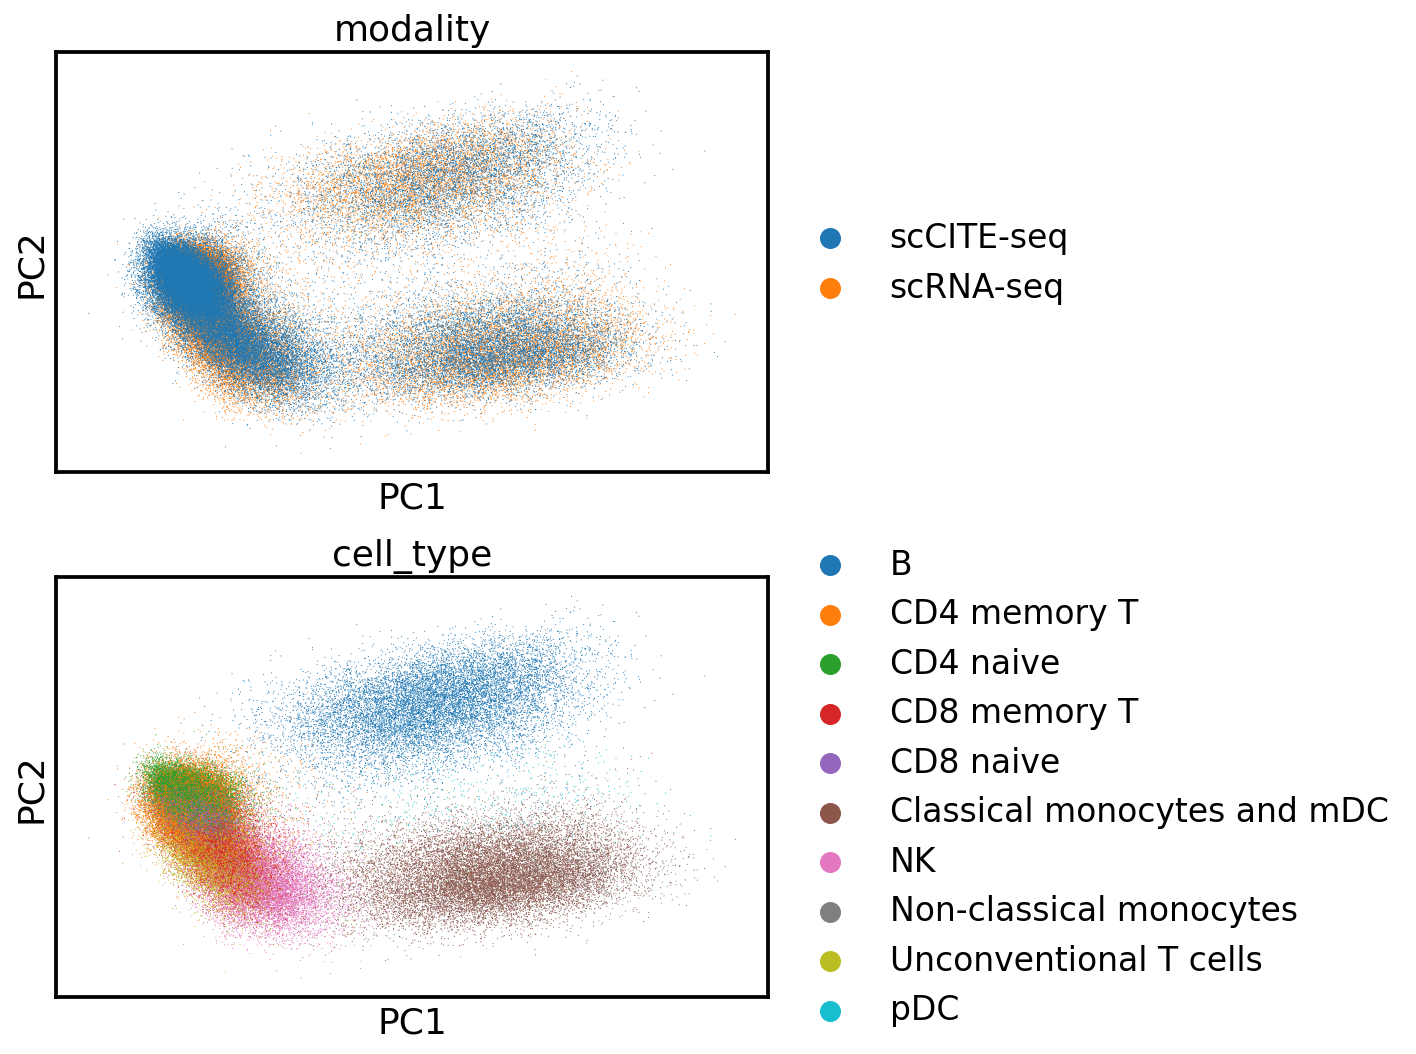

In [13]:
sc.pl.pca(z, color=['modality', 'cell_type'], ncols = 1)

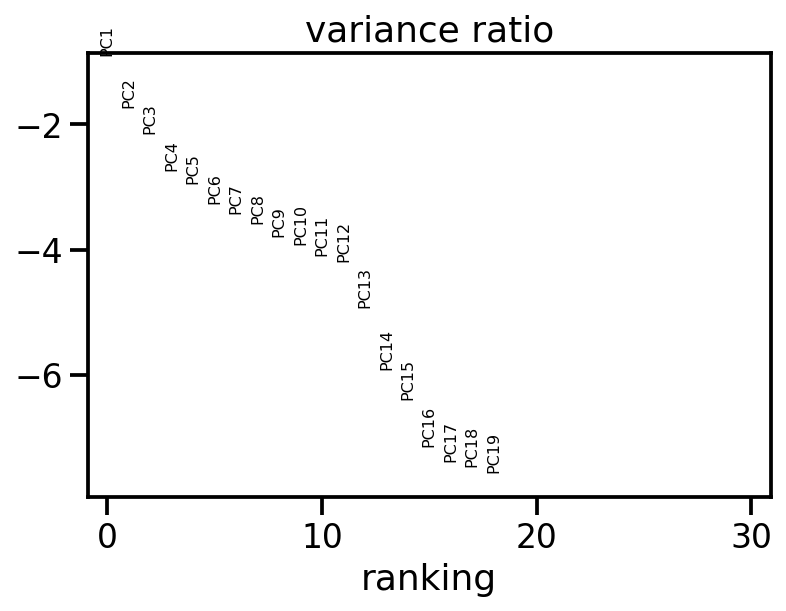

In [14]:
sc.pl.pca_variance_ratio(z, log=True)

In [15]:
# use smaller number of neighbours than the default to make it run faster
sc.pp.neighbors(z, n_neighbors=10, n_pcs=16)

/Users/alitinet/opt/miniconda3/envs/mulgr/lib/python3.7/site-packages/scanpy/neighbors/__init__.py:121: FutureWarning: This location for 'distances' is deprecated. It has been moved to .obsp[distances], and will not be accesible here in a future version of anndata.
  adata.uns['neighbors']['distances'] = neighbors.distances
/Users/alitinet/opt/miniconda3/envs/mulgr/lib/python3.7/site-packages/scanpy/neighbors/__init__.py:122: FutureWarning: This location for 'connectivities' is deprecated. It has been moved to .obsp[connectivities], and will not be accesible here in a future version of anndata.
  adata.uns['neighbors']['connectivities'] = neighbors.connectivities


In [16]:
sc.tl.umap(z)

/Users/alitinet/opt/miniconda3/envs/mulgr/lib/python3.7/site-packages/scanpy/tools/_umap.py:147: FutureWarning: This location for 'connectivities' is deprecated. It has been moved to .obsp[connectivities], and will not be accesible here in a future version of anndata.
  adata.uns['neighbors']['connectivities'].tocoo(),


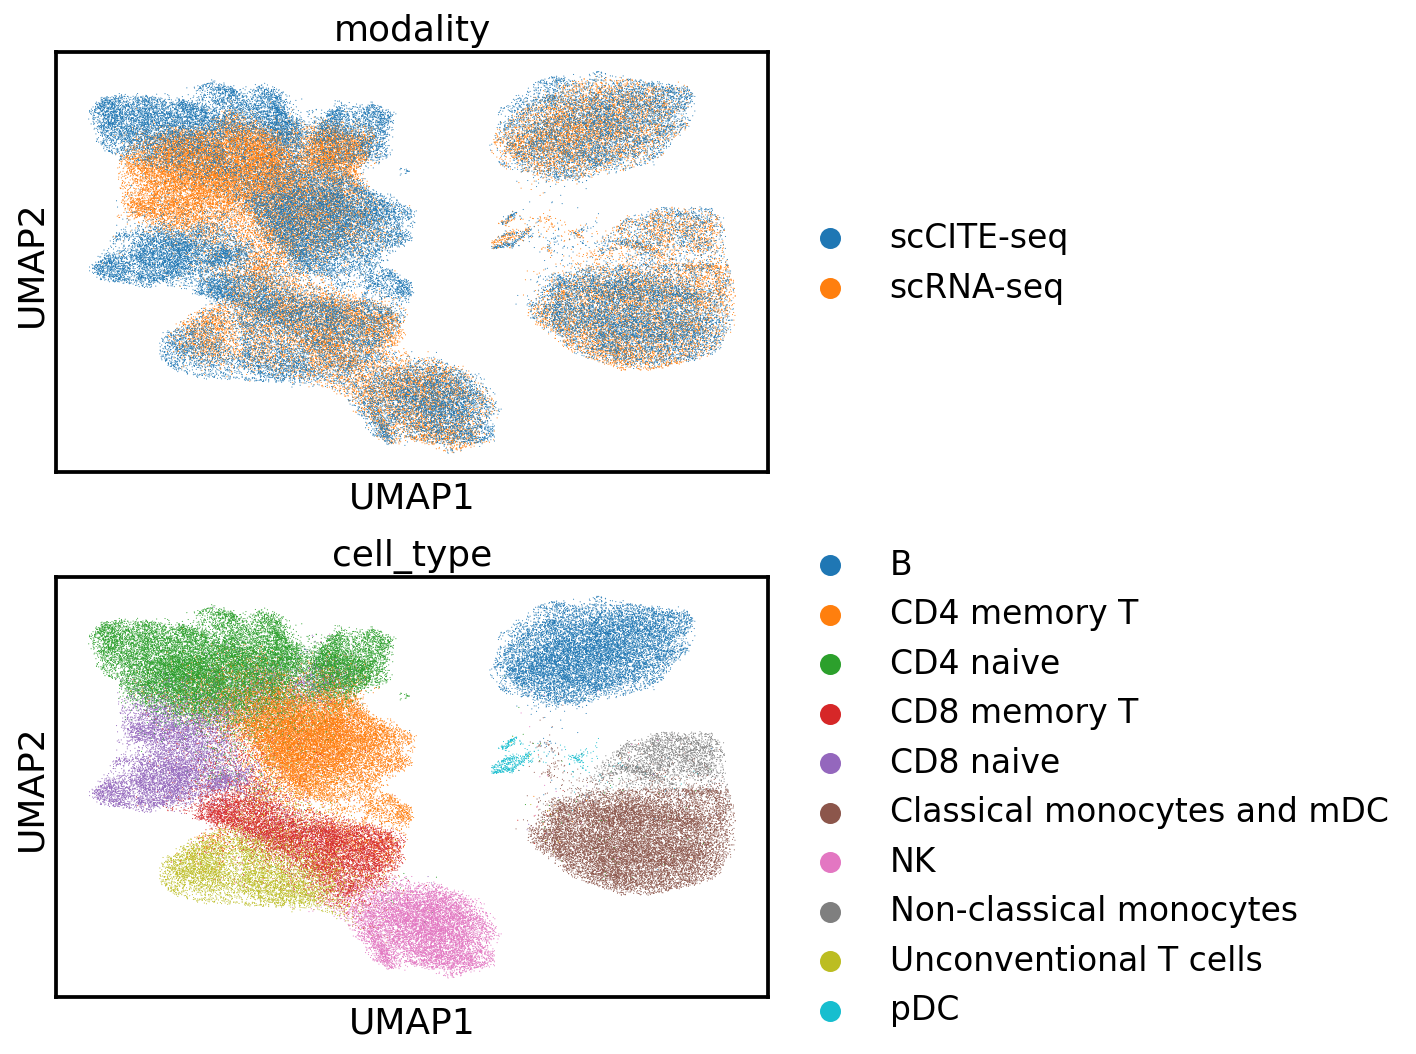

In [17]:
sc.pl.umap(z, color=['modality', 'cell_type'], ncols=1)

## Metrics

In [18]:
scmulti.metrics.nmi(z, label_key='modality')

1.2864584148370877e-05

In [19]:
scmulti.metrics.asw(z, label_key='modality')

0.004758152179419994

In [6]:
# doesn't work yet because of some weird louvain/scanpy/
metrics = scmulti.metrics.scibmetrics.metrics(
    z, z,
    batch_key='modality',
    label_key='cell_type',
    hvg_score_=False,
    nmi_=True,
    ari_=True,
    silhouette_=True,
)
metrics

clustering...


/Users/alitinet/opt/miniconda3/envs/mulgr/lib/python3.7/site-packages/scanpy/tools/_louvain.py:107: FutureWarning: This location for 'connectivities' is deprecated. It has been moved to .obsp[connectivities], and will not be accesible here in a future version of anndata.
  adjacency = adata.uns['neighbors']['connectivities']
/Users/alitinet/opt/miniconda3/envs/mulgr/lib/python3.7/site-packages/scanpy/tools/_louvain.py:107: FutureWarning: This location for 'connectivities' is deprecated. It has been moved to .obsp[connectivities], and will not be accesible here in a future version of anndata.
  adjacency = adata.uns['neighbors']['connectivities']
/Users/alitinet/opt/miniconda3/envs/mulgr/lib/python3.7/site-packages/scanpy/tools/_louvain.py:107: FutureWarning: This location for 'connectivities' is deprecated. It has been moved to .obsp[connectivities], and will not be accesible here in a future version of anndata.
  adjacency = adata.uns['neighbors']['connectivities']
/Users/alitinet/opt

NMI...
ARI...
silhouette score...


0
NMI_cluster/label          0.628787
ARI_cluster/label          0.400657
ASW_label                  0.590996
ASW_label/batch            0.936893
PCR_batch                       NaN
cell_cycle_conservation         NaN
isolated_label_F1               NaN
isolated_label_silhouette       NaN
graph_conn                      NaN
kBET                            NaN
iLISI                           NaN
cLISI                           NaN
hvg_overlap                     NaN
trajectory                      NaN

# Unpaired setting

## Shuffle

In [8]:
def shuffle_adata(adata):
    
    mapIndexPosition = list(zip(list(adata.obs_names), range(len(adata.obs_names))))
    shuffle(mapIndexPosition)
    obs_names, idx = zip(*mapIndexPosition)
    
    if sparse.issparse(adata.X):        
        x = adata.X.A[idx, :]
    else:
        x = adata.X[idx, :]
        
    adata.obs_names = adata.obs_names.astype(str).str.strip()
    adata.obs.loc[list(obs_names), :]
    
    return ad.AnnData(x, obs=adata.obs.loc[list(obs_names), :])

In [9]:
scrna_shuffled = shuffle_adata(scrna)
cite_shuffled = shuffle_adata(cite)

## Configure and train the model

In [10]:
# unpaired
model = scmulti.models.MultiVAE(
    adatas=[[scrna_shuffled], [cite_shuffled]],
    names=[['scRNA-seq'], ['scCITE-seq']],
    pair_groups=[[0], [1]],
    z_dim=20,
    h_dim=128,
    hiddens=[],
    shared_hiddens=[],
    adver_hiddens=[],
    recon_coef=1,
    kl_coef=1e-5,
    integ_coef=1e-2,
    cycle_coef=0,
    adversarial=False,
    dropout=0.2,
)

In [11]:
model.train(
    n_iters=10000,
    batch_size=256,
    lr=3e-4,
    val_split=0.1,
    adv_iters=0,
)

In [12]:
z_shuffled = model.predict(
    adatas=[[scrna_shuffled], [cite_shuffled]],
    names=[['scRNA-seq'], ['scCITE-seq']],
    batch_size=256,
)
z_shuffled

AnnData object with n_obs × n_vars = 106392 × 20
    obs: 'modality', 'cell_type', 'batch'

## Recover and visualize the latent space

In [13]:
sc.tl.pca(z_shuffled, svd_solver='arpack')

... storing 'modality' as categorical
... storing 'cell_type' as categorical


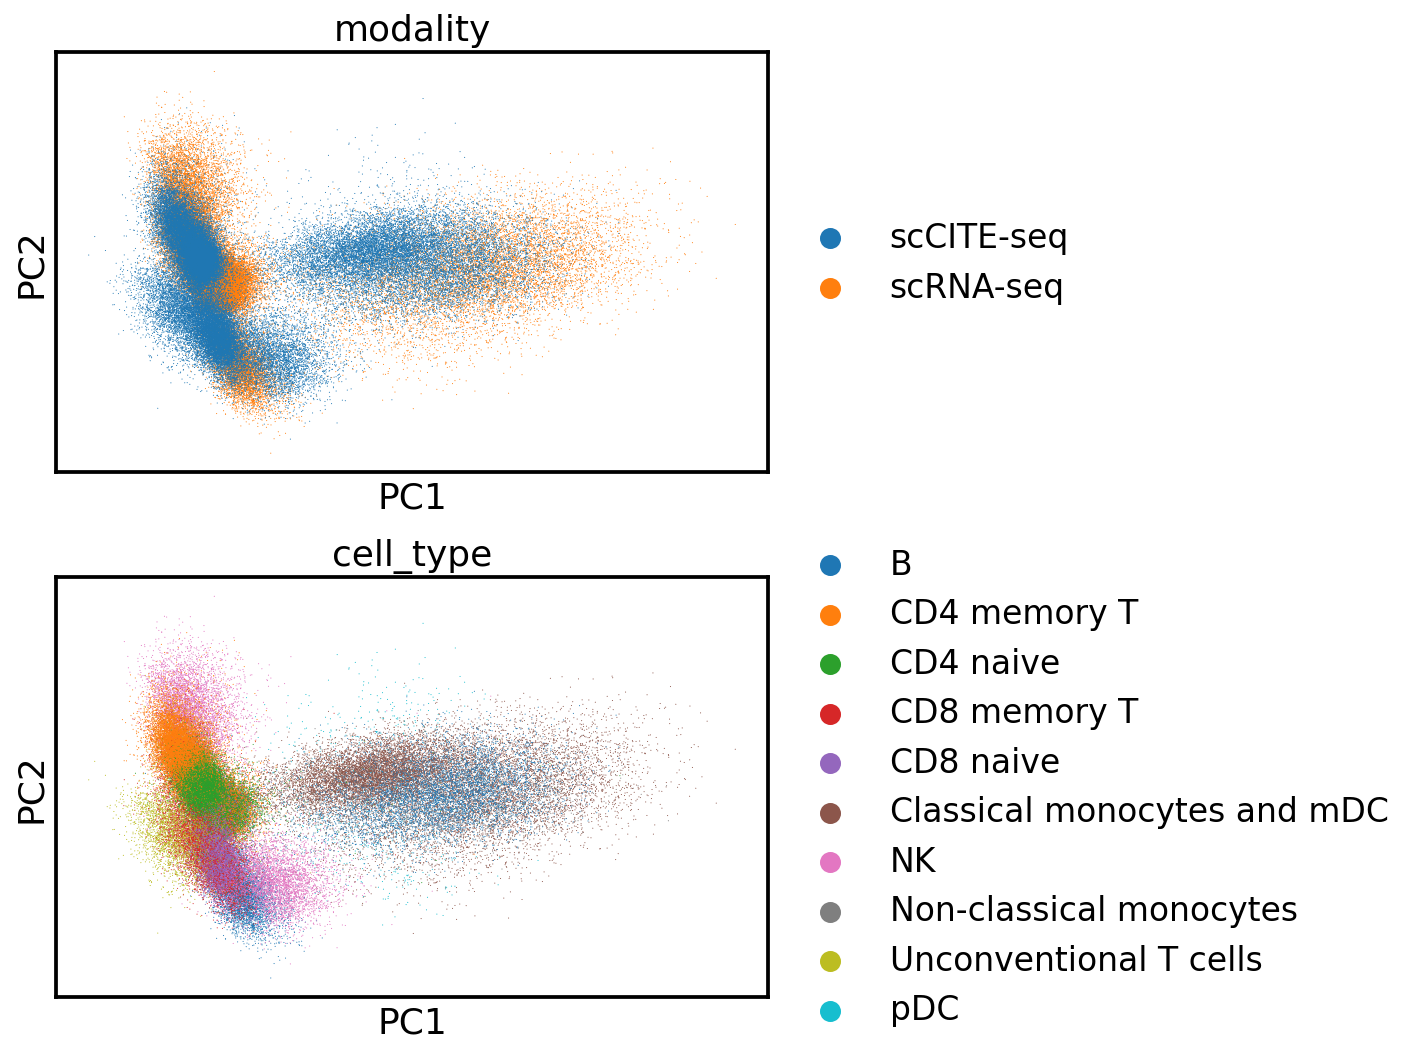

In [14]:
sc.pl.pca(z_shuffled, color=['modality', 'cell_type'], ncols = 1)

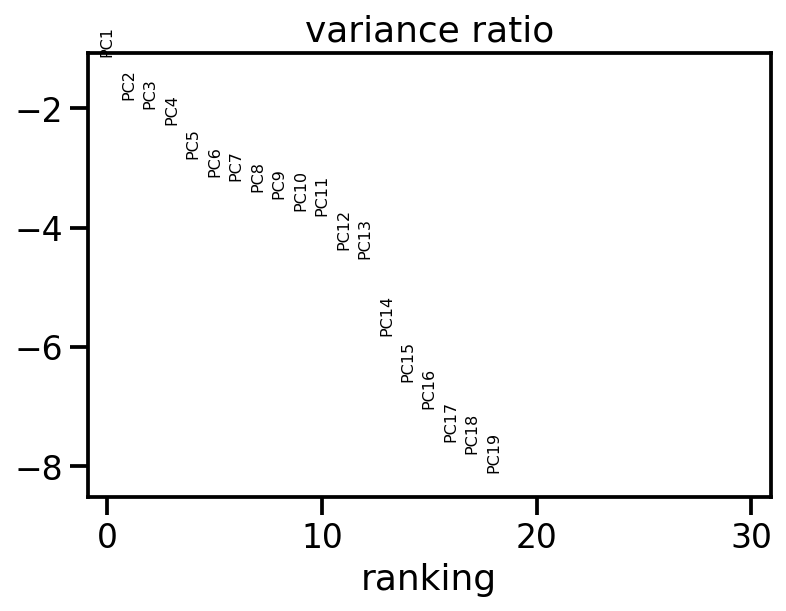

In [15]:
sc.pl.pca_variance_ratio(z_shuffled, log=True)

In [16]:
# use smaller number of neighbours than the default to make it run faster
sc.pp.neighbors(z_shuffled, n_neighbors=10, n_pcs=16)

/Users/alitinet/opt/miniconda3/envs/mulgr/lib/python3.7/site-packages/scanpy/neighbors/__init__.py:121: FutureWarning: This location for 'distances' is deprecated. It has been moved to .obsp[distances], and will not be accesible here in a future version of anndata.
  adata.uns['neighbors']['distances'] = neighbors.distances
/Users/alitinet/opt/miniconda3/envs/mulgr/lib/python3.7/site-packages/scanpy/neighbors/__init__.py:122: FutureWarning: This location for 'connectivities' is deprecated. It has been moved to .obsp[connectivities], and will not be accesible here in a future version of anndata.
  adata.uns['neighbors']['connectivities'] = neighbors.connectivities


In [17]:
sc.tl.umap(z_shuffled)

/Users/alitinet/opt/miniconda3/envs/mulgr/lib/python3.7/site-packages/scanpy/tools/_umap.py:147: FutureWarning: This location for 'connectivities' is deprecated. It has been moved to .obsp[connectivities], and will not be accesible here in a future version of anndata.
  adata.uns['neighbors']['connectivities'].tocoo(),


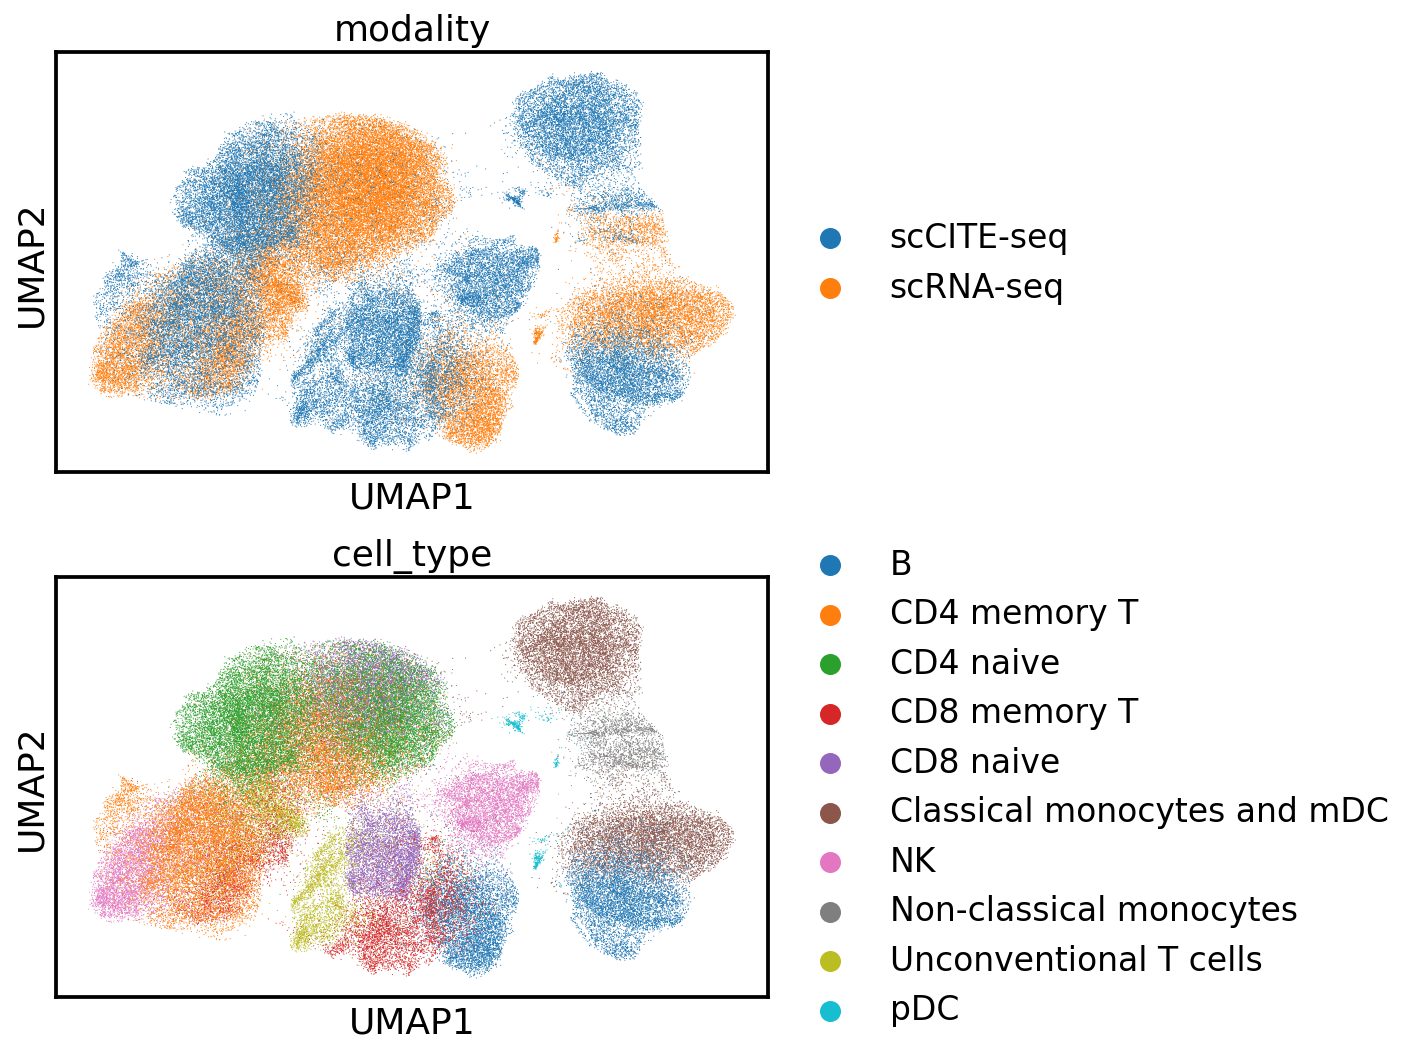

In [18]:
sc.pl.umap(z_shuffled, color=['modality', 'cell_type'], ncols=1)

## Metrics

In [19]:
scmulti.metrics.nmi(z_shuffled, label_key='modality')

0.009978048546997083

In [20]:
scmulti.metrics.asw(z_shuffled, label_key='modality')

0.009534415788948536

In [21]:
metrics = scmulti.metrics.scibmetrics.metrics(
    z_shuffled, z_shuffled,
    batch_key='modality',
    label_key='cell_type',
    hvg_score_=False,
    nmi_=True,
    ari_=True,
    silhouette_=True,
)
metrics

clustering...


/Users/alitinet/opt/miniconda3/envs/mulgr/lib/python3.7/site-packages/scanpy/tools/_louvain.py:107: FutureWarning: This location for 'connectivities' is deprecated. It has been moved to .obsp[connectivities], and will not be accesible here in a future version of anndata.
  adjacency = adata.uns['neighbors']['connectivities']
/Users/alitinet/opt/miniconda3/envs/mulgr/lib/python3.7/site-packages/scanpy/tools/_louvain.py:107: FutureWarning: This location for 'connectivities' is deprecated. It has been moved to .obsp[connectivities], and will not be accesible here in a future version of anndata.
  adjacency = adata.uns['neighbors']['connectivities']
/Users/alitinet/opt/miniconda3/envs/mulgr/lib/python3.7/site-packages/scanpy/tools/_louvain.py:107: FutureWarning: This location for 'connectivities' is deprecated. It has been moved to .obsp[connectivities], and will not be accesible here in a future version of anndata.
  adjacency = adata.uns['neighbors']['connectivities']
/Users/alitinet/opt

NMI...
ARI...
silhouette score...


0
NMI_cluster/label          0.473878
ARI_cluster/label          0.227214
ASW_label                  0.500844
ASW_label/batch            0.664515
PCR_batch                       NaN
cell_cycle_conservation         NaN
isolated_label_F1               NaN
isolated_label_silhouette       NaN
graph_conn                      NaN
kBET                            NaN
iLISI                           NaN
cLISI                           NaN
hvg_overlap                     NaN
trajectory                      NaN